In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("new_iso1_group_names.csv")  # Adjust path if needed

# Preview the first few rows
df.head()


,Blend Number,Original Blend Name,Blend Type,Replacement Level,Group_names,PC,GPP,SC,CC,FA,VA,GBA,FBC,QUARTZ,PLC,Cumulative Heat (J/g)
0,0,100% PC,Other,0,X,100,0,0,0,0,0,0,0,0,0,323.16
1,1,80% PC + 20% GPP,Binary,20,Group_1_PC_GP,80,20,0,0,0,0,0,0,0,0,297.77
2,2,70% PC + 30% GPP,Binary,30,Group_1_PC_GP,70,30,0,0,0,0,0,0,0,0,311.40
3,3,60% PC + 40% GPP,Binary,40,Group_1_PC_GP,60,40,0,0,0,0,0,0,0,0,265.35
4,4,50% PC + 50% GPP,Binary,50,Group_1_PC_GP,50,50,0,0,0,0,0,0,0,0,225.05


In [5]:
# Extract Quartz-based Binary blends at 30%, 40%, 50% binder levels
reference_blends = df[
    (df['Blend Type'] == 'Binary') &
    (df['QUARTZ'] > 0) &
    (
        ((df['PC'].isin([30, 40, 50])) & (df['PLC'] == 0)) |
        ((df['PLC'].isin([30, 40, 50])) & (df['PC'] == 0))
    )
]

# View the result
reference_blends[['Original Blend Name', 'PC', 'PLC', 'QUARTZ', 'Cumulative Heat (J/g)']]


,Original Blend Name,PC,PLC,QUARTZ,Cumulative Heat (J/g)
47,50% PC + 50% QUARTZ,50,0,50,224.65
48,40% PC + 60% QUARTZ,40,0,60,180.19
49,30% PC + 70% QUARTZ,30,0,70,145.39
91,50% PLC + 50% QUARTZ,0,50,50,200.71


In [6]:
# Show rows where PLC is 30 or 40 and QUARTZ > 0
df[
    (df['PLC'].isin([30, 40])) &
    (df['QUARTZ'] > 0)
][['Original Blend Name', 'PC', 'PLC', 'QUARTZ', 'Cumulative Heat (J/g)']]


,Original Blend Name,PC,PLC,QUARTZ,Cumulative Heat (J/g)


In [7]:
# Show ALL rows with QUARTZ > 0 and PLC > 0
df[
    (df['QUARTZ'] > 0) & (df['PLC'] > 0)
][['Original Blend Name', 'PC', 'PLC', 'QUARTZ', 'Blend Type']]


,Original Blend Name,PC,PLC,QUARTZ,Blend Type
87,90% PLC + 10% QUARTZ,0,90,10,Binary
88,80% PLC + 20% QUARTZ,0,80,20,Binary
89,70% PLC + 30% QUARTZ,0,70,30,Binary
90,60% PLC + 40% QUARTZ,0,60,40,Binary
91,50% PLC + 50% QUARTZ,0,50,50,Binary


In [12]:
# Build reference lookup again using known 4 Quartz-based reference blends
reference_lookup = {
    ('PC', 30): 145.39,
    ('PC', 40): 180.19,
    ('PC', 50): 224.65,
    ('PLC', 50): 200.71
}

# Assign reference heat to each row (for ternary only)
def assign_reference(row):
    if row['Blend Type'] != 'Ternary':
        return None
    if row['PC'] > 0:
        return reference_lookup.get(('PC', int(row['PC'])))
    elif row['PLC'] > 0:
        return reference_lookup.get(('PLC', int(row['PLC'])))
    return None

# Apply to full dataframe
df['Reference_Heat'] = df.apply(assign_reference, axis=1)

# ΔHeat = Actual - Reference
df['Delta_Heat'] = df['Cumulative Heat (J/g)'] - df['Reference_Heat']


In [13]:
# Recreate valid_ternary from df (after ΔHeat was added)
valid_ternary = df[
    (df['Blend Type'] == 'Ternary') & 
    (df['Reference_Heat'].notna())
][[
    'Original Blend Name', 'PC', 'PLC', 'GPP', 'SC', 'FA', 'CC', 'VA', 'GBA', 'FBC',
    'Cumulative Heat (J/g)', 'Reference_Heat', 'Delta_Heat'
]]


In [20]:
# Step 1: Define function to create group label
def generate_group_label(row):
    if row['PC'] > 0:
        binder_type = 'PC'
        binder_pct = int(row['PC'])
    elif row['PLC'] > 0:
        binder_type = 'PLC'
        binder_pct = int(row['PLC'])
    else:
        return "Unknown"

    # Extract SCMs used in this blend
    scms = ['GPP', 'SC', 'FA', 'CC', 'VA', 'GBA', 'FBC']
    scm_data = {scm: row[scm] for scm in scms if row[scm] > 0}
    total = sum(scm_data.values())

    if total == 0:
        return f"{binder_type}-{binder_pct} | No SCMs"

    # Normalize to 10-part ratios
    norm = {k: int(round(v / total * 10)) for k, v in scm_data.items()}
    ratio_str = ":".join([f"{k}={v}" for k, v in norm.items()])
    return f"{binder_type}-{binder_pct} | {ratio_str}"

# Step 2: Apply label to the filtered ternary DataFrame
valid_ternary['SCM_Group_Label'] = valid_ternary.apply(generate_group_label, axis=1)

# Step 3: Group by SCM label and compute average heat and ΔHeat
summary = valid_ternary.groupby('SCM_Group_Label').agg({
    'Cumulative Heat (J/g)': 'mean',
    'Reference_Heat': 'mean',
    'Delta_Heat': 'mean'
}).reset_index().sort_values(by='SCM_Group_Label')

# Optional: Round for presentation
summary = summary.round(2)


summary.head()

,SCM_Group_Label,Cumulative Heat (J/g),Reference_Heat,Delta_Heat
0,PC-30 | GPP=1:FBC=9,173.40,145.39,28.01
1,PC-30 | GPP=1:GBA=9,164.78,145.39,19.39
2,PC-30 | GPP=1:SC=9,222.55,145.39,77.16
3,PC-30 | GPP=1:VA=9,154.31,145.39,8.92
4,PC-30 | GPP=3:FBC=7,170.58,145.39,25.19


In [ ]:
summary.sort_values('Delta_Heat', ascending=False).head(20)  # Top 20 by ΔHeat

,SCM_Group_Label,Cumulative Heat (J/g),Reference_Heat,Delta_Heat
2,PC-30 | GPP=1:SC=9,222.55,145.39,77.16
11,PC-30 | GPP=4:SC=6,217.65,145.39,72.26
20,PC-30 | GPP=7:SC=3,202.64,145.39,57.25
14,PC-30 | GPP=6:FA=4,198.80,145.39,53.41
6,PC-30 | GPP=3:SC=7,194.64,145.39,49.25
17,PC-30 | GPP=7:FA=3,192.39,145.39,47.00
23,PC-30 | GPP=9:SC=1,183.33,145.39,37.94
13,PC-30 | GPP=6:CC=4,182.54,145.39,37.15
15,PC-30 | GPP=6:SC=4,180.43,145.39,35.04
16,PC-30 | GPP=7:CC=3,179.90,145.39,34.51


C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\4048399911.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\4048399911.py:23: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128314 (\N{UP-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


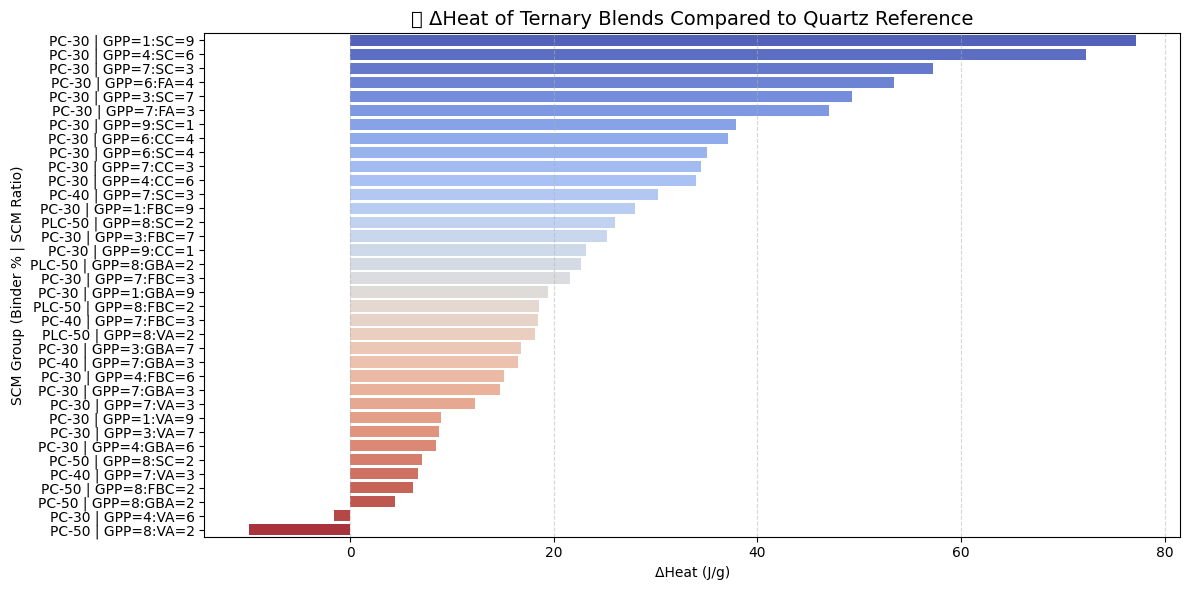

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort groups by ΔHeat for better visual flow
summary_sorted = summary.sort_values(by='Delta_Heat', ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Create barplot
sns.barplot(
    data=summary_sorted,
    y='SCM_Group_Label',
    x='Delta_Heat',
    palette='coolwarm'
)

# Add labels and title
plt.title("🔺 ΔHeat of Ternary Blends Compared to Quartz Reference", fontsize=14)
plt.xlabel("ΔHeat (J/g)")
plt.ylabel("SCM Group (Binder % | SCM Ratio)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\1039528876.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\1039528876.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


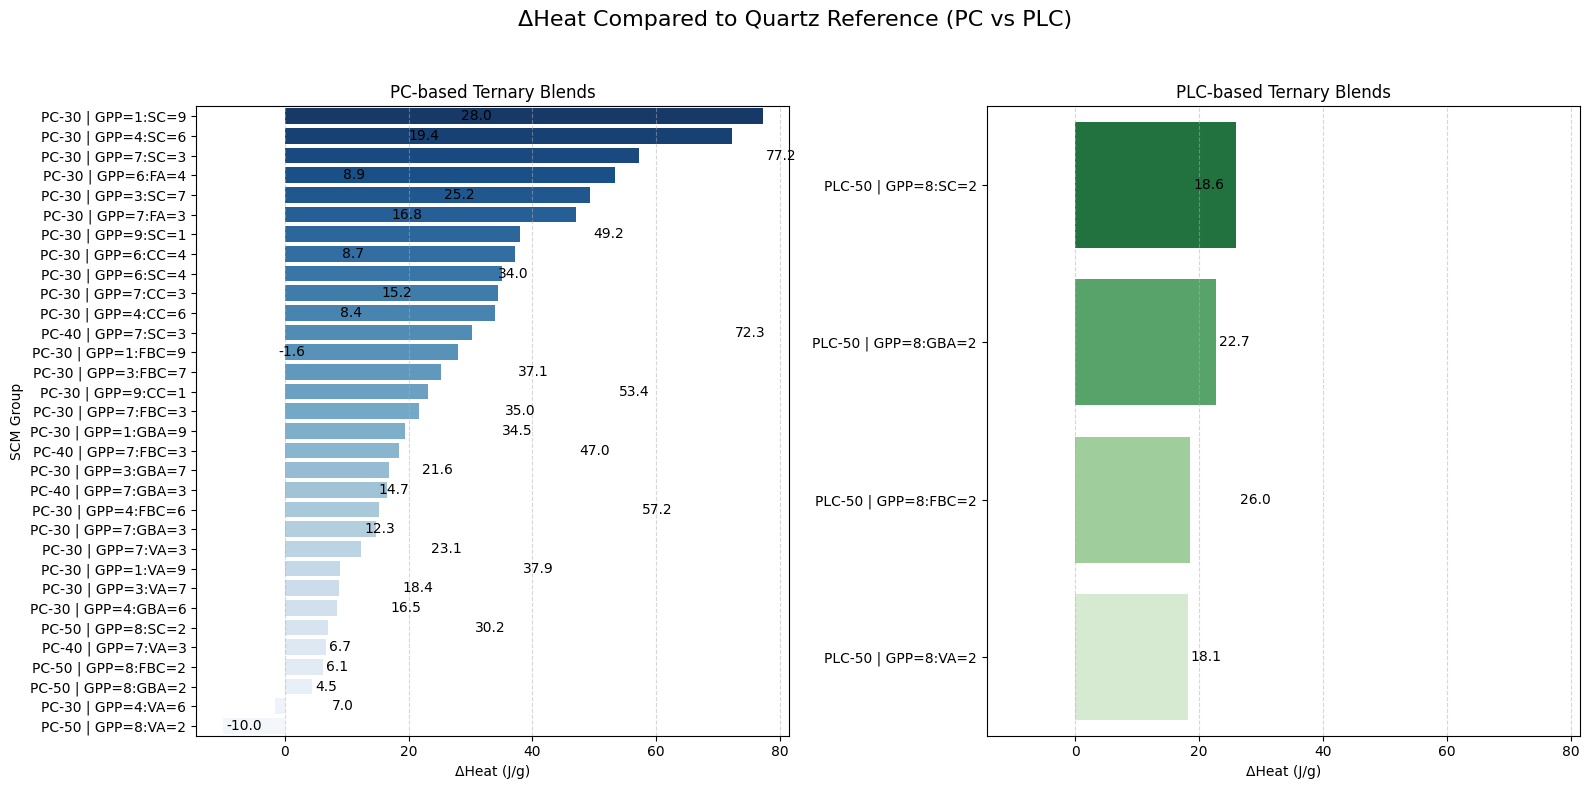

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and prepare data
summary_pc = summary[summary['SCM_Group_Label'].str.startswith('PC')].sort_values(by='Delta_Heat', ascending=False)
summary_plc = summary[summary['SCM_Group_Label'].str.startswith('PLC')].sort_values(by='Delta_Heat', ascending=False)

# Plot layout
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# --- PC Plot with annotations ---
sns.barplot(
    data=summary_pc,
    y='SCM_Group_Label',
    x='Delta_Heat',
    palette='Blues_r',
    ax=axes[0]
)
axes[0].set_title("PC-based Ternary Blends")
axes[0].set_xlabel("ΔHeat (J/g)")
axes[0].set_ylabel("SCM Group")
axes[0].grid(True, axis='x', linestyle='--', alpha=0.5)

# Add annotations to bars
for index, row in summary_pc.iterrows():
    axes[0].text(row['Delta_Heat'] + 0.5, index, f"{row['Delta_Heat']:.1f}", va='center')

# --- PLC Plot with annotations ---
sns.barplot(
    data=summary_plc,
    y='SCM_Group_Label',
    x='Delta_Heat',
    palette='Greens_r',
    ax=axes[1]
)
axes[1].set_title("PLC-based Ternary Blends")
axes[1].set_xlabel("ΔHeat (J/g)")
axes[1].set_ylabel("")
axes[1].grid(True, axis='x', linestyle='--', alpha=0.5)

for index, row in summary_plc.iterrows():
    axes[1].text(row['Delta_Heat'] + 0.5, index - summary_pc.shape[0], f"{row['Delta_Heat']:.1f}", va='center')

# Final layout
plt.suptitle("ΔHeat Compared to Quartz Reference (PC vs PLC)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\3837732336.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\3837732336.py:15: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


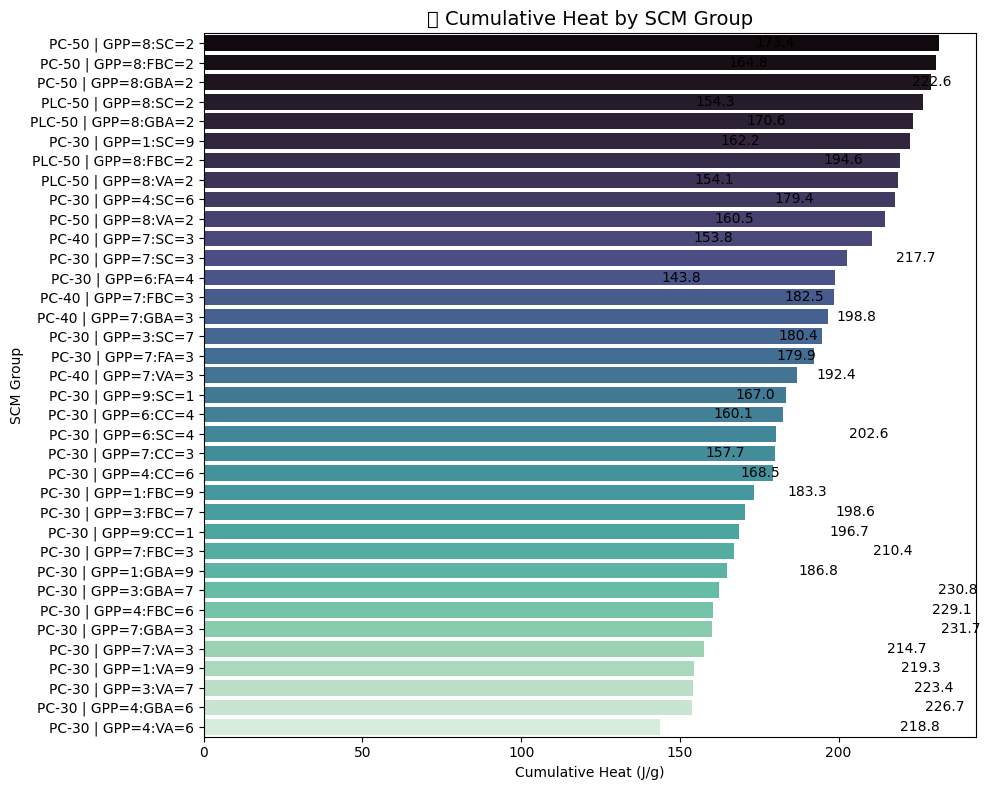

In [27]:
# Sort and plot actual cumulative heat
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=summary.sort_values(by='Cumulative Heat (J/g)', ascending=False),
    x='Cumulative Heat (J/g)',
    y='SCM_Group_Label',
    palette='mako',
    ax=ax
)
ax.set_title("🔥 Cumulative Heat by SCM Group", fontsize=14)
ax.set_xlabel("Cumulative Heat (J/g)")
ax.set_ylabel("SCM Group")
for i, row in summary.iterrows():
    ax.text(row['Cumulative Heat (J/g)'] + 0.5, i, f"{row['Cumulative Heat (J/g)']:.1f}", va='center')
plt.tight_layout()
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\993940597.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_ternary, x='SCM_Count', y='Delta_Heat', palette='Set2')
C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\993940597.py:14: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


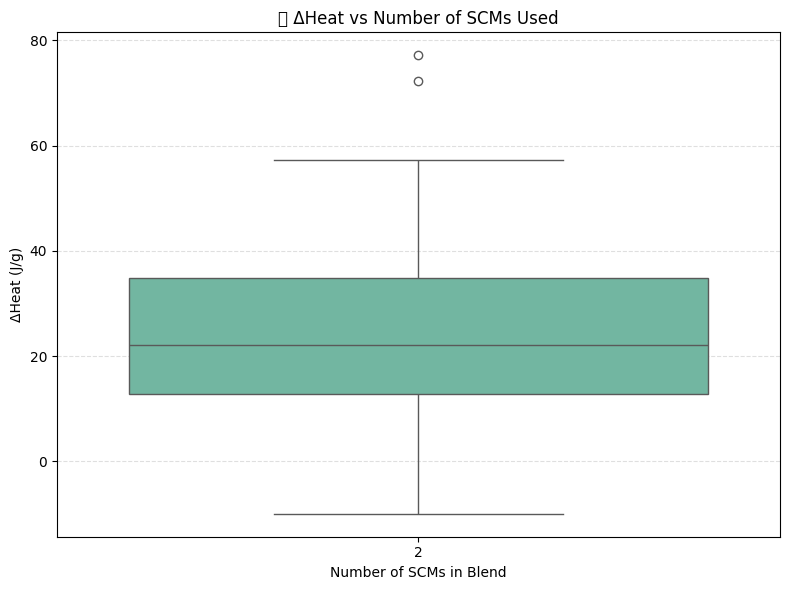

In [28]:
# Count how many SCMs are used in each blend
def count_scms(row):
    return sum(row[scm] > 0 for scm in ['GPP', 'SC', 'FA', 'CC', 'VA', 'GBA', 'FBC'])

valid_ternary['SCM_Count'] = valid_ternary.apply(count_scms, axis=1)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=valid_ternary, x='SCM_Count', y='Delta_Heat', palette='Set2')
plt.title("🧪 ΔHeat vs Number of SCMs Used")
plt.xlabel("Number of SCMs in Blend")
plt.ylabel("ΔHeat (J/g)")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\1047869158.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scm_avg.values, y=scm_avg.index, palette='Spectral')
C:\Users\raksh\AppData\Local\Temp\ipykernel_34076\1047869158.py:21: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


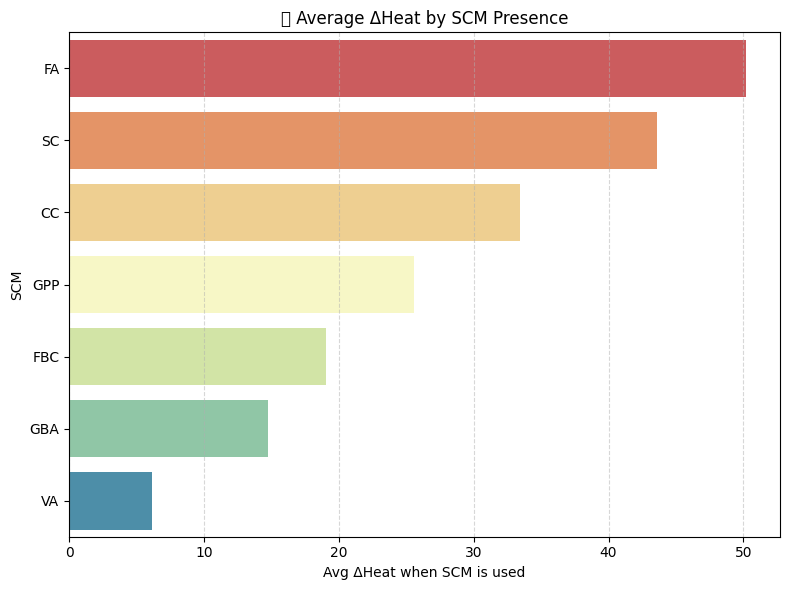

In [ ]:
# Melt the SCM columns to analyze them individually
melted = valid_ternary.melt(
    id_vars=['Delta_Heat'],
    value_vars=['GPP', 'SC', 'FA', 'CC', 'VA', 'GBA', 'FBC'],
    var_name='SCM',
    value_name='SCM_Content'
)

# Filter non-zero SCMs
melted = melted[melted['SCM_Content'] > 0]

# Group by SCM and compute average ΔHeat
scm_avg = melted.groupby('SCM')['Delta_Heat'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=scm_avg.values, y=scm_avg.index, palette='Spectral')
plt.title("Average ΔHeat by SCM Presence")
plt.xlabel("Avg ΔHeat when SCM is used")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [30]:
# Step 1: Filter only binary and ternary blends
model_data = df[df['Blend Type'].isin(['Binary', 'Ternary'])].copy()

# Step 2: Drop rows where binder + SCMs don’t sum ~100 (ensure realistic blends)
blend_cols = ['PC', 'PLC', 'GPP', 'SC', 'FA', 'CC', 'VA', 'GBA', 'FBC']
model_data['Total'] = model_data[blend_cols].sum(axis=1)
model_data = model_data[(model_data['Total'] >= 98) & (model_data['Total'] <= 102)]

# Step 3: Define X (features) and y (target)
X = model_data[blend_cols]
y = model_data['Cumulative Heat (J/g)']

# Preview shape
print(f"✅ Model dataset size: {X.shape[0]} blends with {X.shape[1]} features")


✅ Model dataset size: 79 blends with 9 features


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.001)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("KNN Regressor", KNeighborsRegressor(n_neighbors=5))
]

# Store results
results = []

# Train and evaluate each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, round(r2, 4), round(rmse, 2), round(mae, 2)))

# Display as DataFrame
results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE", "MAE"]).sort_values(by="R²", ascending=False)

# Show
print("📊 Model Performance Summary:\n")
print(results_df)


c:\Users\raksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.813e+03, tolerance: 1.104e+01
  model = cd_fast.enet_coordinate_descent(


📊 Model Performance Summary:

               Model      R²   RMSE    MAE
4  Gradient Boosting  0.9475   9.50   7.03
3      Random Forest  0.9301  10.96   9.12
0  Linear Regression  0.9013  13.03  10.26
1   Ridge Regression  0.9013  13.02  10.25
2   Lasso Regression  0.9013  13.03  10.26
5      KNN Regressor  0.7331  21.42  17.47


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

# Retrain on full data
final_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
final_model.fit(X, y)


GradientBoostingRegressor(random_state=42)

In [50]:
def predict_heat_from_user():
    import pandas as pd

    print("📋 Ternary Blend Heat Predictor (Simplified)")
    print("Enter exactly 3 components: 1 Binder + 2 SCMs")

    try:
        # ---- BLANK DICTIONARY FOR INPUTS ----
        blend = {
            'PC': 0.0, 'PLC': 0.0, 'GPP': 0.0, 'FA': 0.0,
            'SC': 0.0, 'CC': 0.0, 'VA': 0.0, 'GBA': 0.0, 'FBC': 0.0
        }

        # --- Step 1: Binder Input ---
        binder = input("🔹 Enter binder name (PC or PLC): ").strip().upper()
        if binder not in ['PC', 'PLC']:
            print("❌ Only 'PC' or 'PLC' allowed.")
            return
        binder_val = float(input(f"→ % {binder}: ").strip())
        if binder_val <= 0:
            print("❌ Binder % must be greater than 0.")
            return
        blend[binder] = binder_val

        # --- Step 2: First SCM ---
        scm1 = input("🔹 Enter first SCM (e.g., GPP, FA, SC...): ").strip().upper()
        if scm1 not in blend or scm1 in ['PC', 'PLC']:
            print("❌ Invalid SCM 1.")
            return
        scm1_val = float(input(f"→ % {scm1}: ").strip())
        if scm1_val <= 0:
            print("❌ SCM 1 % must be greater than 0.")
            return
        blend[scm1] = scm1_val

        # --- Step 3: Second SCM ---
        scm2 = input("🔹 Enter second SCM (not same as first): ").strip().upper()
        if scm2 not in blend or scm2 in ['PC', 'PLC'] or scm2 == scm1:
            print("❌ Invalid or duplicate SCM 2.")
            return
        scm2_val = float(input(f"→ % {scm2}: ").strip())
        if scm2_val <= 0:
            print("❌ SCM 2 % must be greater than 0.")
            return
        blend[scm2] = scm2_val

        # --- Check Total ---
        total = binder_val + scm1_val + scm2_val
        print(f"\n📊 Total Blend = {total:.1f}%")
        if not 98 <= total <= 102:
            print("⚠️ Blend total must be ~100%. Check values.")
            return

        # --- Predict ---
        input_df = pd.DataFrame([blend])[X.columns]  # reorder to match training features
        prediction = final_model.predict(input_df)[0]

        # --- Output ---
        print("\n✅ Input Breakdown:")
        print(f"• {binder}: {binder_val}%")
        print(f"• {scm1}: {scm1_val}%")
        print(f"• {scm2}: {scm2_val}%")
        print(f"\n🔥 Predicted Cumulative Heat: {round(prediction, 2)} J/g")

    except Exception as e:
        print("❌ An error occurred:", str(e))


In [51]:
predict_heat_from_user()

📋 Ternary Blend Heat Predictor (Simplified)
Enter exactly 3 components: 1 Binder + 2 SCMs

📊 Total Blend = 100.0%

✅ Input Breakdown:
• PC: 50.0%
• GPP: 30.0%
• FA: 20.0%

🔥 Predicted Cumulative Heat: 237.55 J/g
